## CUSTOMER CHURN PREDICTION ANALYSIS

## BUSINESS UNDERSTANDING 
Every company wants to increase its profits or revenue margin and customer retention is one of the key area industry players focus their resources on. 
For a telecommunication company, they would like to assess whether their customers are churning and at what rate are they quitting using their products. As it is,it is very costly to bring in new customers as costly as retaining customers to continuously use its service and subscriptions. 

#### OBJECTIVES 
1. Build a model to predict whether a customer will churn or not 
2. Key indicators of churn 
3. Retention startegies to implement 

#### HYPOTHESIS 
*NULL HYPOTHESIS* : There is no relationship between phone service and churn rate  

*ALTERNATIVE HYPOTHESIS* : There is a relationship between phone service and churn rate

#### ANALYTICAL QUESTIONS
1. Which gender is churning at a high rate?
2. Is there a relationship between the monthly charges and the likelyhood to churn?
3. How does the availability of internet services impact churn?
4. Does the presence of a partner impact the churn rate of a customer?
5. What is the lifespan of a customer?
6. Does mode of payment influence the customer to leave?
7. Is there correlation between subscriptions and churn rate?


In [1]:
## IMPORT NECESSARY LIBRARIES 
import pyodbc     
from dotenv import dotenv_values    
import pandas as pd
import numpy as np
import os

## Import visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## import others
import warnings 

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

#scikit learn import
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
 

In [2]:
## Data environment access
# Load environment variables from .env file into a dictionary
environment_variables=dotenv_values('.env')


# Get the values for the credentials you set in the '.env' 
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")


connection_string= f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# connect your data using pyodbc
connection=pyodbc.connect(connection_string)

### DATA UNDERSTANDING

TASKS 
1. Load our datasets
2. Check for the quality of the data 
3. Conduct an EDA analysis

##### DATA FEATURES 
| COLUMN | DESCRIPTION|
|:---: | :---         |
|**Gender** | Whether the customer is a male or a female|
|**SeniorCitizen** | Whether a customer is a senior citizen or not|
|**Partner** | Whether the customer has a partner or not (Yes, No)|
|**Dependents** | Whether the customer has dependents or not (Yes, No)|
|**Tenure** | Number of months the customer has stayed with the company|
|**Phone Service** | Whether the customer has a phone service or not (Yes, No)|
|**MultipleLines** | Whether the customer has multiple lines or not|
|**InternetService** | Customer's internet service provider (DSL, Fiber Optic, No)|
|**OnlineSecurity** | Whether the customer has online security or not (Yes, No, No Internet)|
|**OnlineBackup** | Whether the customer has online backup or not (Yes, No, No Internet)|
|**DeviceProtection** | Whether the customer has device protection or not (Yes, No, No internet service)|
|**TechSupport** | Whether the customer has tech support or not (Yes, No, No internet)|
|**StreamingTV** | Whether the customer has streaming TV or not (Yes, No, No internet service)|
|**StreamingMovies** | Whether the customer has streaming movies or not (Yes, No, No Internet service)|
|**Contract** | The contract term of the customer (Month-to-Month, One year, Two year)|
|**PaperlessBilling** | Whether the customer has paperless billing or not (Yes, No)|
|**Payment Method** | The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))|
|**MonthlyCharges** | The amount charged to the customer monthly|
|**TotalCharges** | The total amount charged to the customer|
|**Churn** | Whether the customer churned or not (Yes or No)|


In [4]:
# Now the sql query to get the data is what what you see below.  

query = "SELECT * FROM LP2_Telco_churn_first_3000"

data1 = pd.read_sql(query, connection)
data1.head()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG  Female          False     True       False       1   
1  5575-GNVDE    Male          False    False       False      34   
2  3668-QPYBK    Male          False    False       False       2   
3  7795-CFOCW    Male          False    False       False      45   
4  9237-HQITU  Female          False    False       False       2   

   PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup  \
0         False          None             DSL          False         True   
1          True         False             DSL           True        False   
2          True         False             DSL           True         True   
3         False          None             DSL           True        False   
4          True         False     Fiber optic          False        False   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0            False       False       False           False  Month-to-month   
1             True       False       False           False        One year   
2            False       False       False           False  Month-to-month   
3             True        True       False           False        One year   
4            False       False       False           False  Month-to-month   

   PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              True           Electronic check       29.850000     29.850000   
1             False               Mailed check       56.950001   1889.500000   
2              True               Mailed check       53.849998    108.150002   
3             False  Bank transfer (automatic)       42.299999   1840.750000   
4              True           Electronic check       70.699997    151.649994   

   Churn  
0  False  
1  False  
2   True  
3  False  
4   True

### EDA ANALYSIS ON DATA1

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [6]:
data1.shape

(3000, 21)

In [7]:
data1.duplicated().sum()

0

In [8]:
data1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [9]:
data1.describe(include='all').T

count unique               top  freq         mean  \
customerID          3000   3000        7590-VHVEG     1          NaN   
gender              3000      2              Male  1537          NaN   
SeniorCitizen       3000      2             False  2525          NaN   
Partner             3000      2             False  1538          NaN   
Dependents          3000      2             False  2070          NaN   
tenure            3000.0    NaN               NaN   NaN    32.527333   
PhoneService        3000      2              True  2731          NaN   
MultipleLines       2731      2             False  1437          NaN   
InternetService     3000      3       Fiber optic  1343          NaN   
OnlineSecurity      2349      2             False  1478          NaN   
OnlineBackup        2349      2             False  1320          NaN   
DeviceProtection    2349      2             False  1296          NaN   
TechSupport         2349      2             False  1476          NaN   
StreamingTV         2349      2             False  1190          NaN   
StreamingMovies     2349      2              True  1199          NaN   
Contract            3000      3    Month-to-month  1641          NaN   
PaperlessBilling    3000      2              True  1776          NaN   
PaymentMethod       3000      4  Electronic check  1004          NaN   
MonthlyCharges    3000.0    NaN               NaN   NaN      65.3474   
TotalCharges      2995.0    NaN               NaN   NaN  2301.278315   
Churn               2999      2             False  2219          NaN   

                          std        min        25%          50%          75%  \
customerID                NaN        NaN        NaN          NaN          NaN   
gender                    NaN        NaN        NaN          NaN          NaN   
SeniorCitizen             NaN        NaN        NaN          NaN          NaN   
Partner                   NaN        NaN        NaN          NaN          NaN   
Dependents                NaN        NaN        NaN          NaN          NaN   
tenure              24.637768        0.0        9.0         29.0         56.0   
PhoneService              NaN        NaN        NaN          NaN          NaN   
MultipleLines             NaN        NaN        NaN          NaN          NaN   
InternetService           NaN        NaN        NaN          NaN          NaN   
OnlineSecurity            NaN        NaN        NaN          NaN          NaN   
OnlineBackup              NaN        NaN        NaN          NaN          NaN   
DeviceProtection          NaN        NaN        NaN          NaN          NaN   
TechSupport               NaN        NaN        NaN          NaN          NaN   
StreamingTV               NaN        NaN        NaN          NaN          NaN   
StreamingMovies           NaN        NaN        NaN          NaN          NaN   
Contract                  NaN        NaN        NaN          NaN          NaN   
PaperlessBilling          NaN        NaN        NaN          NaN          NaN   
PaymentMethod             NaN        NaN        NaN          NaN          NaN   
MonthlyCharges      30.137053       18.4  35.787499    70.900002    90.262501   
TotalCharges      2274.987884  18.799999     415.25  1404.650024  3868.725098   
Churn                     NaN        NaN        NaN          NaN          NaN   

                         max  
customerID               NaN  
gender                   NaN  
SeniorCitizen            NaN  
Partner                  NaN  
Dependents               NaN  
tenure                  72.0  
PhoneService             NaN  
MultipleLines            NaN  
InternetService          NaN  
OnlineSecurity           NaN  
OnlineBackup             NaN  
DeviceProtection         NaN  
TechSupport              NaN  
StreamingTV              NaN  
StreamingMovies          NaN  
Contract                 NaN  
PaperlessBilling         NaN  
PaymentMethod            NaN  
MonthlyCharges    118.650002  
TotalCharges         8564.75  


In [10]:
data1.describe().T

count         mean          std        min         25%  \
tenure          3000.0    32.527333    24.637768   0.000000    9.000000   
MonthlyCharges  3000.0    65.347400    30.137053  18.400000   35.787499   
TotalCharges    2995.0  2301.278315  2274.987884  18.799999  415.250000   

                        50%          75%          max  
tenure            29.000000    56.000000    72.000000  
MonthlyCharges    70.900002    90.262501   118.650002  
TotalCharges    1404.650024  3868.725098  8564.750000

In [11]:
data1.value_counts()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  MultipleLines  InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract        PaperlessBilling  PaymentMethod              MonthlyCharges  TotalCharges  Churn
0002-ORFBO  Female  False          True     True        9       True          False          DSL              False           True          False             True         True         False            One year        True              Mailed check               65.599998       593.299988    False    1
6551-GNYDG  Female  False          True     True        14      True          False          Fiber optic      False           False         False             False        False        True             Month-to-month  True              Bank transfer (automatic)  80.900002       1152.800049   False    1
6670-MFRPK  Male    False          True     True        69      True          True           Fib

#### *Observation* 
--- There are certain columns that have boolean values as their data type.

--- In the customer lifespan which is represented in Tenure column in months has an average of 32 which means that it approximately takes 32 months for a customer to churn. The standard deviation holds at 24 months, median at 29% with the highest churn at 72%. 

--- The monthly charges holds a mean at 65.34 with a standard deviation of 30.13.The median holding at 70%

--- The Total charges holds a mean of 2301.27 and standard deviation of 2274.98. Though the results are inflated a bit and might skew the dataset.

#### *Course of action* 
--- Conversion of the boolean values to interger 

--- Feature scaling on the total charges column.


In [12]:
data1['SeniorCitizen']= data1['SeniorCitizen'].astype(int)

In [13]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   int32  
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


### SECOND DATASET

In [14]:
data2=pd.read_csv("data files\LP2_Telco-churn-second-2000.csv")
data2.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  5600-PDUJF    Male              0      No         No       6          Yes   
1  8292-TYSPY    Male              0      No         No      19          Yes   
2  0567-XRHCU  Female              0     Yes        Yes      69           No   
3  1867-BDVFH    Male              0     Yes        Yes      11          Yes   
4  2067-QYTCF  Female              0     Yes         No      64          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0                No             DSL             No           No   
1                No             DSL             No           No   
2  No phone service             DSL            Yes           No   
3               Yes     Fiber optic             No           No   
4               Yes     Fiber optic             No          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes          No              No  Month-to-month   
1              Yes         Yes          No              No  Month-to-month   
2              Yes          No          No             Yes        Two year   
3               No          No          No              No  Month-to-month   
4              Yes         Yes         Yes             Yes  Month-to-month   

  PaperlessBilling            PaymentMethod  MonthlyCharges TotalCharges Churn  
0              Yes  Credit card (automatic)           49.50        312.7    No  
1              Yes  Credit card (automatic)           55.00       1046.5   Yes  
2              Yes  Credit card (automatic)           43.95       2960.1    No  
3              Yes         Electronic check           74.35        834.2   Yes  
4              Yes         Electronic check          111.15       6953.4    No

### EDA ANALYSIS ON DATA2

In [15]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [16]:
data2.shape

(2043, 21)

In [17]:
data2.duplicated().sum()

0

In [18]:
data2.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [19]:
data2.describe().T

count       mean        std    min     25%    50%     75%  \
SeniorCitizen   2043.0   0.168380   0.374295   0.00   0.000   0.00   0.000   
tenure          2043.0  32.649046  24.376248   0.00   9.000  30.00  55.000   
MonthlyCharges  2043.0  64.712555  29.970010  18.55  35.825  70.25  89.625   

                   max  
SeniorCitizen     1.00  
tenure           72.00  
MonthlyCharges  118.35

In [20]:
data2.describe(include='all').T

count unique               top  freq       mean        std  \
customerID          2043   2043        5600-PDUJF     1        NaN        NaN   
gender              2043      2              Male  1022        NaN        NaN   
SeniorCitizen     2043.0    NaN               NaN   NaN    0.16838   0.374295   
Partner             2043      2                No  1047        NaN        NaN   
Dependents          2043      2                No  1412        NaN        NaN   
tenure            2043.0    NaN               NaN   NaN  32.649046  24.376248   
PhoneService        2043      2               Yes  1823        NaN        NaN   
MultipleLines       2043      3                No   987        NaN        NaN   
InternetService     2043      3       Fiber optic   905        NaN        NaN   
OnlineSecurity      2043      3                No  1029        NaN        NaN   
OnlineBackup        2043      3                No   911        NaN        NaN   
DeviceProtection    2043      3                No   923        NaN        NaN   
TechSupport         2043      3                No   996        NaN        NaN   
StreamingTV         2043      3                No   828        NaN        NaN   
StreamingMovies     2043      3                No   831        NaN        NaN   
Contract            2043      3    Month-to-month  1103        NaN        NaN   
PaperlessBilling    2043      2               Yes  1220        NaN        NaN   
PaymentMethod       2043      4  Electronic check   696        NaN        NaN   
MonthlyCharges    2043.0    NaN               NaN   NaN  64.712555   29.97001   
TotalCharges        2043   1991              20.2     5        NaN        NaN   
Churn               2043      2                No  1487        NaN        NaN   

                    min     25%    50%     75%     max  
customerID          NaN     NaN    NaN     NaN     NaN  
gender              NaN     NaN    NaN     NaN     NaN  
SeniorCitizen       0.0     0.0    0.0     0.0     1.0  
Partner             NaN     NaN    NaN     NaN     NaN  
Dependents          NaN     NaN    NaN     NaN     NaN  
tenure              0.0     9.0   30.0    55.0    72.0  
PhoneService        NaN     NaN    NaN     NaN     NaN  
MultipleLines       NaN     NaN    NaN     NaN     NaN  
InternetService     NaN     NaN    NaN     NaN     NaN  
OnlineSecurity      NaN     NaN    NaN     NaN     NaN  
OnlineBackup        NaN     NaN    NaN     NaN     NaN  
DeviceProtection    NaN     NaN    NaN     NaN     NaN  
TechSupport         NaN     NaN    NaN     NaN     NaN  
StreamingTV         NaN     NaN    NaN     NaN     NaN  
StreamingMovies     NaN     NaN    NaN     NaN     NaN  
Contract            NaN     NaN    NaN     NaN     NaN  
PaperlessBilling    NaN     NaN    NaN     NaN     NaN  
PaymentMethod       NaN     NaN    NaN     NaN     NaN  
MonthlyCharges    18.55  35.825  70.25  89.625  118.35  
TotalCharges        NaN     NaN    NaN     NaN     NaN  
Churn               NaN     NaN    NaN     NaN     NaN

#### *Observation* 

--- The total charges are in object data type.

--- The customer lifespan represented in tenure is on average of 32 months with a standard deviation of 24 months and a median of 30%.

--- On monthly charges the average customers range at 64.71 with a standard deviation of 29.97 which is skewed away from the mean. The median is at 70%.

#### *Course of action* 

--- Convert total charges from object to float type.

CLEANING DATA 2

In [21]:
data2['TotalCharges']= pd.to_numeric(data2['TotalCharges'],errors='coerce')

In [22]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


CONCAT THE DATASETS

In [23]:
df= pd.concat([data1,data2], axis=0)
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0    True      False       1        False   
1  5575-GNVDE    Male              0   False      False      34         True   
2  3668-QPYBK    Male              0   False      False       2         True   
3  7795-CFOCW    Male              0   False      False      45        False   
4  9237-HQITU  Female              0   False      False       2         True   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0          None             DSL          False         True            False   
1         False             DSL           True        False             True   
2         False             DSL           True         True            False   
3          None             DSL           True        False             True   
4         False     Fiber optic          False        False            False   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0       False       False           False  Month-to-month             True   
1       False       False           False        One year            False   
2       False       False           False  Month-to-month             True   
3        True       False           False        One year            False   
4       False       False           False  Month-to-month             True   

               PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0           Electronic check       29.850000     29.850000  False  
1               Mailed check       56.950001   1889.500000  False  
2               Mailed check       53.849998    108.150002   True  
3  Bank transfer (automatic)       42.299999   1840.750000  False  
4           Electronic check       70.699997    151.649994   True

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [25]:
df.shape

(5043, 21)

In [26]:
df.duplicated().sum()

0

In [27]:
df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [28]:
df.describe().T

count         mean          std        min         25%  \
SeniorCitizen   5043.0     0.162403     0.368857   0.000000    0.000000   
tenure          5043.0    32.576641    24.529807   0.000000    9.000000   
MonthlyCharges  5043.0    65.090214    30.068133  18.400000   35.775000   
TotalCharges    5035.0  2302.062861  2269.483576  18.799999  417.675003   

                        50%          75%          max  
SeniorCitizen      0.000000     0.000000     1.000000  
tenure            29.000000    56.000000    72.000000  
MonthlyCharges    70.550003    90.050003   118.650002  
TotalCharges    1401.150024  3862.000000  8670.100000

COLUMN CLEANING 

In [29]:
# Assuming churn_df is your dataframe
df['Churn'] = df['Churn'].apply(lambda x: 'No' if x == False else 'Yes')

# Verify that the conversion was successful
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0    True      False       1        False   
1  5575-GNVDE    Male              0   False      False      34         True   
2  3668-QPYBK    Male              0   False      False       2         True   
3  7795-CFOCW    Male              0   False      False      45        False   
4  9237-HQITU  Female              0   False      False       2         True   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0          None             DSL          False         True            False   
1         False             DSL           True        False             True   
2         False             DSL           True         True            False   
3          None             DSL           True        False             True   
4         False     Fiber optic          False        False            False   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0       False       False           False  Month-to-month             True   
1       False       False           False        One year            False   
2       False       False           False  Month-to-month             True   
3        True       False           False        One year            False   
4       False       False           False  Month-to-month             True   

               PaymentMethod  MonthlyCharges  TotalCharges Churn  
0           Electronic check       29.850000     29.850000    No  
1               Mailed check       56.950001   1889.500000    No  
2               Mailed check       53.849998    108.150002   Yes  
3  Bank transfer (automatic)       42.299999   1840.750000    No  
4           Electronic check       70.699997    151.649994   Yes

### Data Visualization

Univariate analysis

Skewed:
SeniorCitizen     1.83
tenure            0.23
MonthlyCharges   -0.24
TotalCharges      0.94
dtype: float64
The skewness of numerical features in the dataset is 2.76


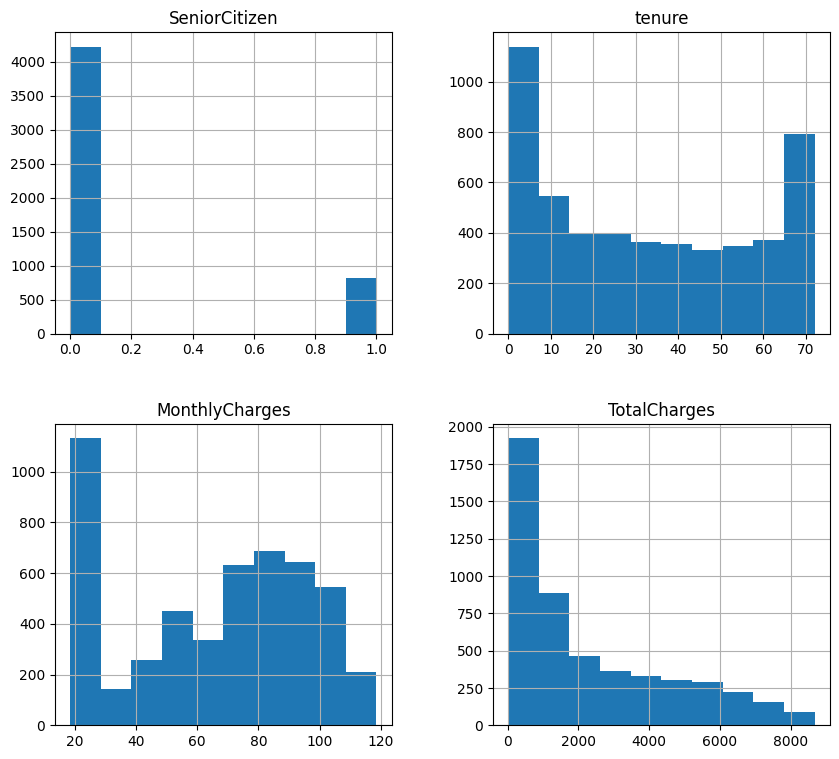

In [30]:
# Check for the skewness and visualize
categoricals = [column for column in df.columns if (df[column].dtype == "O")]
print('Skewed:')
print(round(df.drop(categoricals,axis=1).skew(), 2))


# Total skewness in categorical columns
skew = df.drop(categoricals,axis=1).skew().sum()
print (f'The skewness of numerical features in the dataset is {round(skew,2)}')

# Visualize using histogram
df.hist(figsize=(10,9))
plt.show()

In [31]:
numerics= df.select_dtypes(include=['number']).columns
numerics


for column in df[numerics].columns:
    fig = px.box(df[numerics], y = column,
                 color=df["Churn"], 
                 labels={"color": "Churn"},
                 title = f"Boxplot of the {column} column")
    
    fig.show()

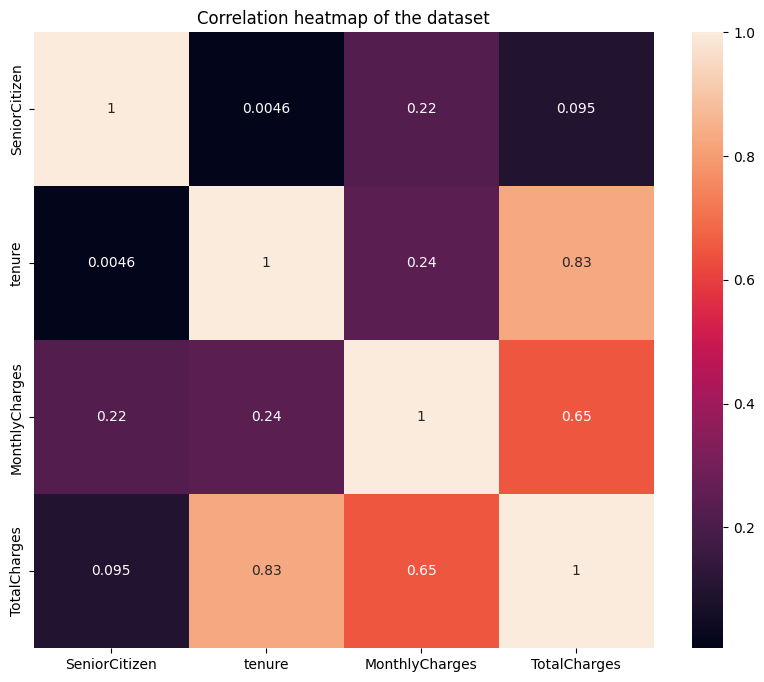

In [32]:
# The correlation of numeric values 

correlation_matrix = df.corr(numeric_only= True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation heatmap of the dataset")
plt.show()

In [33]:
# Visualization of the distribution of categorical columns
categoricals = [column for column in df.columns if (df[column].dtype == "O")]

for column in df[categoricals].columns:
    # Visualizing the distribution of the categories in the column
    fig = px.histogram(df, x=df[column], text_auto=True,
                       title=f"Distribution of values in the {column} column")
    fig.show()

In [34]:
# Variation of service attributes offered by the telecommunication company
service_attributes=df[['PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection','TechSupport'
                    ]]
service_attributes



for column in service_attributes:
    fig = px.histogram(df, x=df[column], color='Churn', text_auto=True, color_discrete_sequence=['purple', 'steelblue'],
                       title=f"Impact of additional services {column} column")
    fig.show()

BIVARIATE ANALYSIS

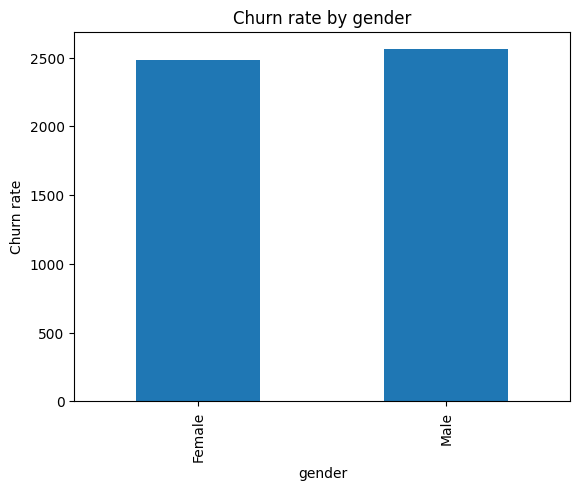

In [35]:
# Calculate the churn rate by gender
churn_rate_by_gender = df.groupby('gender')['Churn'].count()

# Plot the churn rate by gender
churn_rate_by_gender.plot(kind='bar')
plt.ylabel('Churn rate')
plt.title('Churn rate by gender')
plt.show()


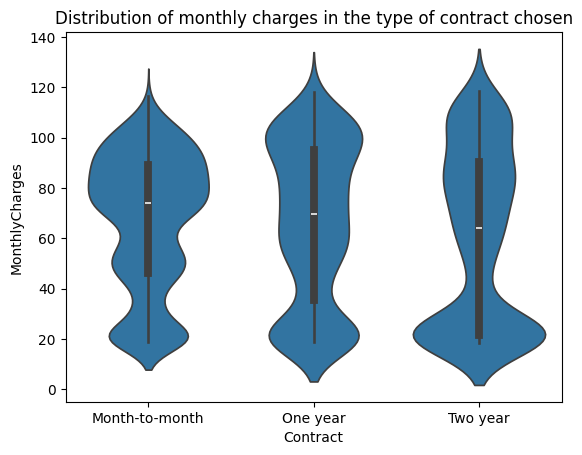

In [36]:
# Check for the relationship of contract type and payments made on a monthly basis
sns.violinplot(data=df, x='Contract', y='MonthlyCharges')
plt.title('Distribution of monthly charges in the type of contract chosen')
plt.show()

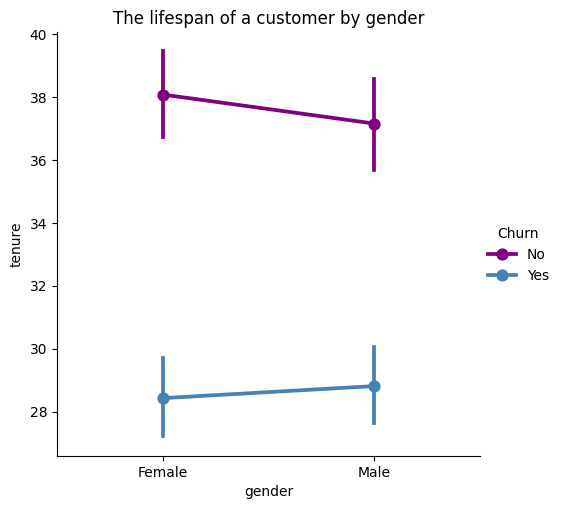

In [37]:
# Check which gender has a minimal lifespan
ax= sns.catplot(data=df, x='gender', y='tenure', hue='Churn', kind='point', palette=['purple', 'steelblue'])
plt.title("The lifespan of a customer by gender")
plt.show()

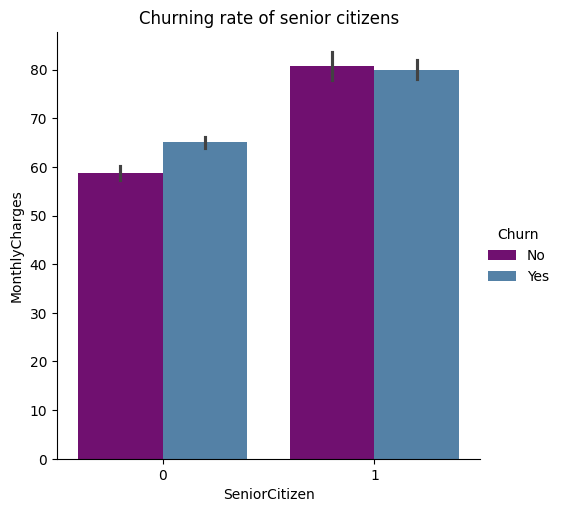

In [38]:
# check whether those who are senior citizens churn more than those who are not
sns.catplot(df, x="SeniorCitizen", y="MonthlyCharges", hue="Churn" , kind="bar",
            palette=["purple", "steelblue"])
plt.title("Churning rate of senior citizens")

plt.show()


MULTIVARIATE ANALYSIS

In [39]:
# Check for the impact of subscription services 
subscription_services =["StreamingTV", "StreamingMovies"]

subscription_rate= df.groupby("Churn")[subscription_services].count()
subscription_rate

StreamingTV  StreamingMovies
Churn                              
No            1607             1607
Yes           2785             2785

In [40]:
for column in subscription_rate:
    fig=px.histogram(df, x=df[column], y= "MonthlyCharges", text_auto=True,
                    color_discrete_sequence=["purple","steelblue"],marginal="box",
                     color="Churn")
    
    fig.show()

ANALYTICAL QUESTIONS

Q1. Which gender is churning at a high rate?

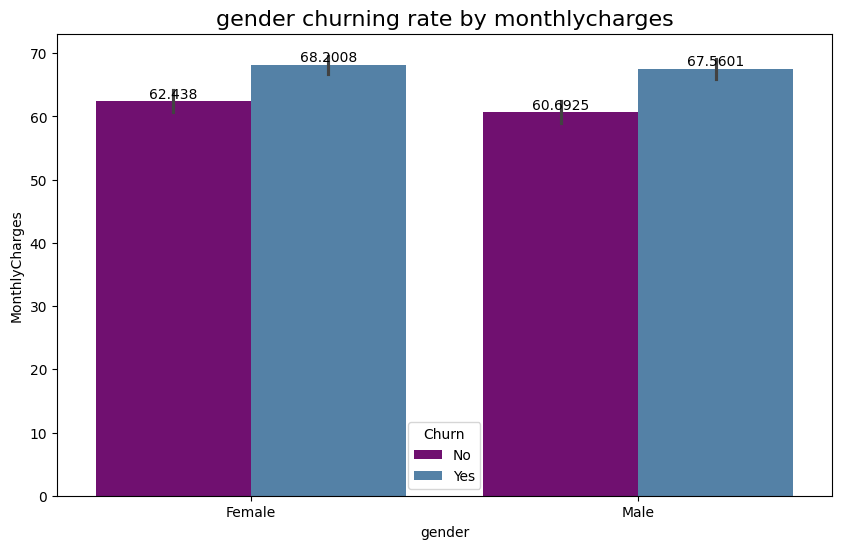

In [41]:
plt.figure(figsize=(10,6))
ax= sns.barplot(data=df, x='gender', y='MonthlyCharges', hue='Churn', legend=True, palette=['purple', 'steelblue'])
plt.title('gender churning rate by monthlycharges', fontsize= 16)
for i in ax.containers:
    ax.bar_label(i,)

#### *REVIEW*

*Both genders seem to be impacted and are churning at a high rate but females are leading with 1% larger than the males however, they still remain to be the highest gender that is not churning.*

Q2. Is there a relationship between the monthly charges and the likelyhood to churn?

In [42]:
monthlycharge_churn= df.groupby('Churn')['MonthlyCharges'].agg(['sum'])
monthlycharge_churn

sum
Churn               
No     136560.000004
Yes    191689.950006

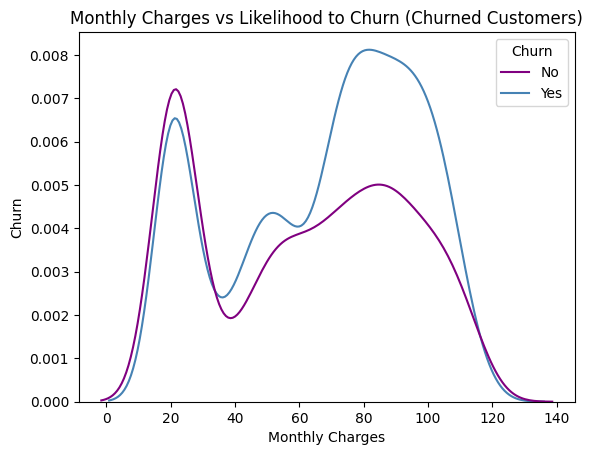

In [43]:

# Create a plot with seaborn
sns.kdeplot(x='MonthlyCharges', data=df, hue='Churn', legend=True, palette=['purple', 'steelblue'])

# Set the title and labels
plt.title("Monthly Charges vs Likelihood to Churn (Churned Customers)")
plt.xlabel('Monthly Charges')
plt.ylabel('Churn')

# # Add a text annotation for each point
# for i, point in enumerate(df[['MonthlyCharges', 'Churn']].values):
#     plt.text(point[0], point[1], i, fontsize=8, color='black', ha="center", va="bottom")

# Show the plot
plt.show()

#### *REVIEW*

*The amount which a customer pays is influencing the churn rate. From the graph, the more monthly charges a customer incurs the more likely he or she is going to leave the company especially where charges are ranging from 80 to 100*

Q3. How does availability of internet services impact churn?

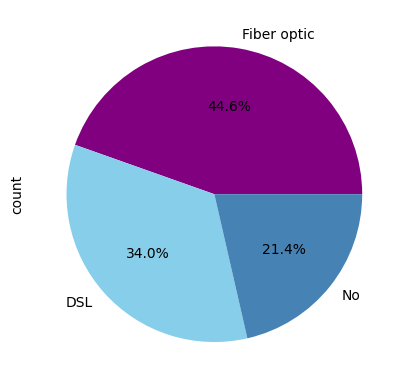

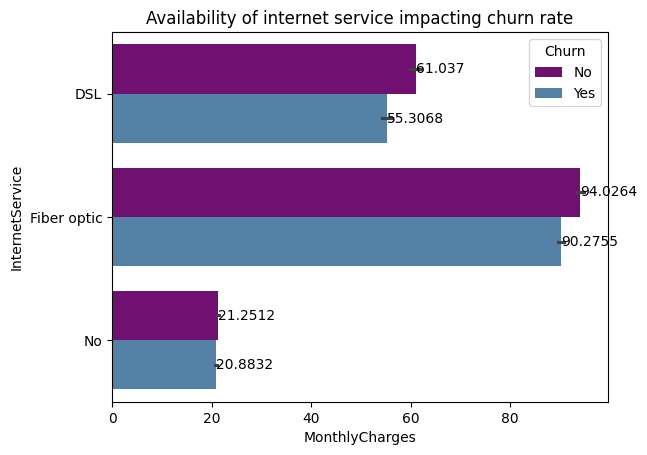

In [44]:
# Check for the counts of internet service
df['InternetService'].value_counts().plot.pie( 
                                              colors=["purple","skyblue","steelblue"],
                                              autopct="%1.1f%%")
plt.show()

# Plot intenet service against churn
ax= sns.barplot(data=df, y='InternetService', x='MonthlyCharges',
                hue='Churn', orient='h', palette=["purple","steelblue"])
plt.title("Availability of internet service impacting churn rate")
for i in ax.containers:
    ax.bar_label(i,)
plt.show()



#### *REVIEW* 

*The Internet service of choice for most customers is fiber optic leading at 44.6% followed by DSL at 34%. Nevertheless, the most preferred internet service is also the most churned among the three services at 90% but in regards internet services does not impact the rate at which customers are leaving as the No is higher than the yes for all the internet services*

Q4. DOES THE PRESENCE OF A PARTNER AFFECT THE LIKELY HOOD OF CUSTOMER CHURN

In [45]:
Partner= df.groupby('Churn')['Partner'].count().rename('Totalcount').reset_index()
Partner

Churn  Totalcount
0    No        2219
1   Yes        2824

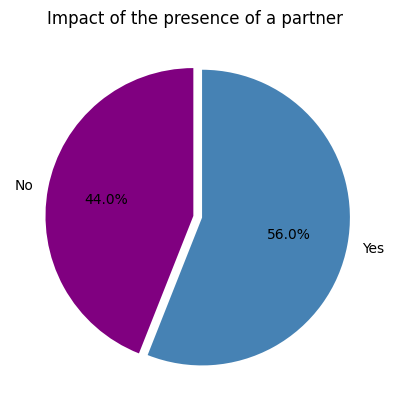

In [46]:
plt.pie(data=Partner, labels='Churn', x='Totalcount',startangle=90, 
        autopct="%1.1f%%",
        explode=(0.01,0.05),
        colors=["purple", "steelblue"])
plt.title("Impact of the presence of a partner")
plt.show()

#### *REVIEW* 

*While there are those who are not impacted by the presence of a partner, 56% of customers leaving have been influenced by their partners*

Q5. What is the lifespan of customers?

Average lifespan of a customer:  32.5766408883601


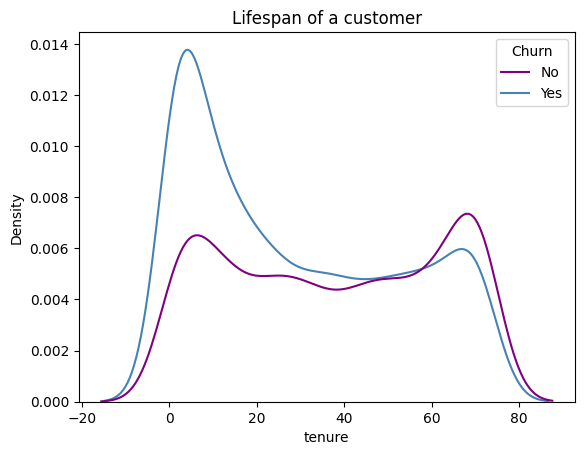

In [47]:
# Calculate the average lifespan of a customer
avg_lifespan = df["tenure"].mean()
print("Average lifespan of a customer: ", avg_lifespan)

# Visualize the lifespan overtime 
ax= sns.kdeplot(data=df, x='tenure', hue='Churn', 
                legend=True, palette=['purple','steelblue'])
plt.title("Lifespan of a customer")
plt.show()

#### Review

*The average customer churns at 32 months which is close to 2 to 3 years.However, the majority of customers leaving at a high rate between entry point of experiencing the service and 20 months.*

Q6. DOES MODE OF PAYMENT INFLUENCE THE CUSTOMER TO LEAVE?

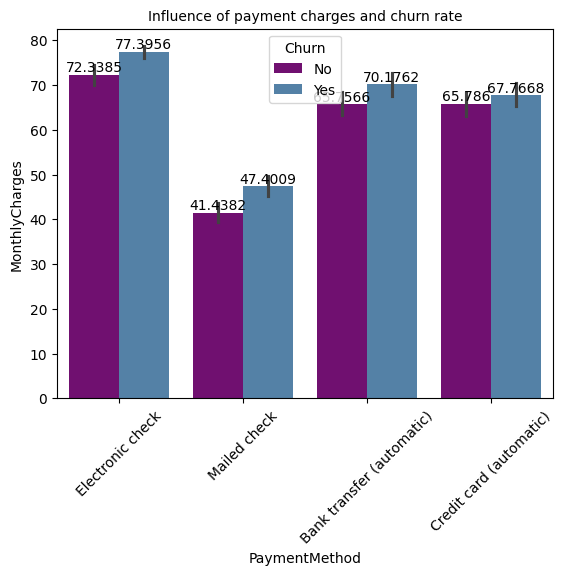

In [48]:
ax= sns.barplot(data=df, x='PaymentMethod', y='MonthlyCharges', hue='Churn', palette=['purple', 'steelblue'])
plt.title('Influence of payment charges and churn rate', fontsize=10)
plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

#### Review

*Electronic check had a major influence in the level of customer churn with a rate of 77% followed with Bank transfer at 70%. This means that the mode of payment is affecting the rate at which customers are interacting with the payment services being offered by the company.*

### HYPOTHESIS 

*NULL HYPOTHESIS* : There is no likelyhood of customers leaving before 3 yrs elapse

*ALTERNATIVE HYPOTHESIS* : There is a likelyhood of customers leaving before 3yrs elapse.

In [49]:
import scipy.stats as stats
# Create a subset of the DataFrame with 'churn' and 'tenure' columns
churn_tenure = df[['Churn', 'tenure']]

# Separate tenure values for churned and non-churned customers
churned_tenure = churn_tenure[churn_tenure['Churn'] == 'Yes']['tenure']
non_churned_tenure = churn_tenure[churn_tenure['Churn'] == 'No']['tenure']

# Perform two-sample independent t-test assuming equal variances
t_statistic, p_value = stats.ttest_ind(churned_tenure, non_churned_tenure, equal_var=True)

# Define the significance level (alpha)
alpha = 0.05

# Interpret the results of the t-test
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in tenure between churned and non-churned customers.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in tenure between churned and non-churned customers.")
print(f'The p-value is {p_value}')
print(f'The t-statistic is {t_statistic}')

Reject the null hypothesis. There is a significant difference in tenure between churned and non-churned customers.
The p-value is 8.512127641958309e-39
The t-statistic is -13.138801320085733


### **KEY INSIGHTS**

--- The total charges is positive skewed, hence it may inflate our model. Our monthly charges is negatively skewed. Tenure is normally distributed.

--- There is also a significant difference between the lifespan of a customer and churn rate. More customers are churning at the beginning of using the services.

--- Among the attributes/ services that impact the churning of the customer include: monthly charges, partner, mode of payment, streamingtv, streamingmovies, gender and tenure. The company needs to delve down into these key aspects.

--- The lifespan of a customers is also closely correlated with the total charges a customer pays thus this need further assessment. 


### **RECOMMENDATIONS**

There is a need of assessment in terms of how they offer services to its customers and the charges in which a customer incurs while using the service. Some of the  recommendation would be:

--- Offering after sales services in order to gain customer feedback.

--- Restructring of the price offerings that favour the majority.

--- Creating a more seamless and effortless payment mode transactions and offering extension to contracts attracting more customers to sign up for longer contract services.

--- Bringing on board customer partners and offering offers to them and create loyalty coupons for those with partners.


### DATA PREPARATION AND CLEANING

*TASKS*

1.  Fill in the missing values 

2.  Feature scaling the numeric columns

3.  Drop useless columns if any 

4.  Clean the categorical columns by creating uniformity of variables 

5.  Feature engineering of the columns through encoding.

In [50]:
df= df.reset_index(drop=True)

In [51]:
# replace and lower column names
df.columns = [col_name.lower() for col_name in df.columns]
df.head()

customerid  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  7590-VHVEG  Female              0    True      False       1        False   
1  5575-GNVDE    Male              0   False      False      34         True   
2  3668-QPYBK    Male              0   False      False       2         True   
3  7795-CFOCW    Male              0   False      False      45        False   
4  9237-HQITU  Female              0   False      False       2         True   

  multiplelines internetservice onlinesecurity onlinebackup deviceprotection  \
0          None             DSL          False         True            False   
1         False             DSL           True        False             True   
2         False             DSL           True         True            False   
3          None             DSL           True        False             True   
4         False     Fiber optic          False        False            False   

  techsupport streamingtv streamingmovies        contract paperlessbilling  \
0       False       False           False  Month-to-month             True   
1       False       False           False        One year            False   
2       False       False           False  Month-to-month             True   
3        True       False           False        One year            False   
4       False       False           False  Month-to-month             True   

               paymentmethod  monthlycharges  totalcharges churn  
0           Electronic check       29.850000     29.850000    No  
1               Mailed check       56.950001   1889.500000    No  
2               Mailed check       53.849998    108.150002   Yes  
3  Bank transfer (automatic)       42.299999   1840.750000    No  
4           Electronic check       70.699997    151.649994   Yes

In [52]:
# drop customer ID Column
df.drop('customerid', axis=1, inplace=True )

In [53]:
# Create a function to get the columns where False, True, Yes and No are present
def check_column_values(df):
    columns = []
    for column in df.columns:
        unique_values = df[column].astype(str).unique()  # Convert values to strings
        if all(value.lower() in [x.lower() for x in unique_values] for value in ['True', 'False', 'Yes', 'No']):
            columns.append(column)
    return columns
def filtered_target_columns(check_column_values):
    target_columns = check_column_values(df)
    return target_columns
target_columns = filtered_target_columns(check_column_values)
target_columns

['partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'paperlessbilling']

In [54]:

# Create a function that maps the column values and replaces True with Yes and False with No
def unify_column_values(df,columns):
    for column in columns:
        df[column]=df[column].replace({True:'Yes',False:'No'})
def unified_columns():
    return target_columns
 
unify_column_values(df,unified_columns())

# Create a function to print the unified columns and the number of values for each category
def get_clean_target_columns(df, target_columns):
    def clean_target_columns(column):
        return column
    result = {}
    for column in df.columns:
        if column in target_columns:
            column_values = df[column].value_counts()
            column_values.columns = [column, 'count']
            result[clean_target_columns(column)] = column_values
    for column, column_df in result.items():
        print(f"\nColumn: {column}")
        print(column_df)
get_clean_target_columns(df, target_columns)


Column: partner
partner
No     2585
Yes    2458
Name: count, dtype: int64

Column: dependents
dependents
No     3482
Yes    1561
Name: count, dtype: int64

Column: phoneservice
phoneservice
Yes    4554
No      489
Name: count, dtype: int64

Column: multiplelines
multiplelines
No                  2424
Yes                 2130
No phone service     220
Name: count, dtype: int64

Column: onlinesecurity
onlinesecurity
No                     2507
Yes                    1456
No internet service     429
Name: count, dtype: int64

Column: onlinebackup
onlinebackup
No                     2231
Yes                    1732
No internet service     429
Name: count, dtype: int64

Column: deviceprotection
deviceprotection
No                     2219
Yes                    1744
No internet service     429
Name: count, dtype: int64

Column: techsupport
techsupport
No                     2472
Yes                    1491
No internet service     429
Name: count, dtype: int64

Column: streamingtv
streamingt

In [55]:
def randoms_sample_imputation(df):
   
    cols_with_missing_values = df.columns[df.isna().any()].tolist()

    for var in cols_with_missing_values:

        # extract a random sample
        random_sample_df = df[var].dropna().sample(df[var].isnull().sum(),
                                                  random_state=0)
        # re-index the randomly extracted sample
        random_sample_df.index = df[
            df[var].isnull()].index

        # replace the NA
        df.loc[df[var].isnull(), var] = random_sample_df
 
    return df

In [56]:
# handle missing values 
df = randoms_sample_imputation(df)
df.head()

gender  seniorcitizen partner dependents  tenure phoneservice  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

  multiplelines internetservice onlinesecurity onlinebackup deviceprotection  \
0            No             DSL             No          Yes               No   
1            No             DSL            Yes           No              Yes   
2            No             DSL            Yes          Yes               No   
3            No             DSL            Yes           No              Yes   
4            No     Fiber optic             No           No               No   

  techsupport streamingtv streamingmovies        contract paperlessbilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges churn  
0           Electronic check       29.850000     29.850000    No  
1               Mailed check       56.950001   1889.500000    No  
2               Mailed check       53.849998    108.150002   Yes  
3  Bank transfer (automatic)       42.299999   1840.750000    No  
4           Electronic check       70.699997    151.649994   Yes

#### DATASET SPLIT

In [57]:
# display your target column and create a list for future reference
df['churn'].unique()

churn={'No', 'Yes'}
X= {'No': 0, 'Yes': 1}
reverse={0:'No', 1:'Yes'}

In [58]:
# lets now split our data to train, evaluate and test the model

#predictor variables
X = df.drop(columns=["churn"], axis=1)
y = df["churn"]

# #split data
X_train, X_eval, y_train, y_eval = train_test_split(X, y, train_size = 0.8, random_state=42)
(X_train.shape, y_train.shape), (X_eval.shape, y_eval.shape)


(((4034, 19), (4034,)), ((1009, 19), (1009,)))

In [59]:
# encoder = OneHotEncoder(sparse=False,handle_unknown='ignore',dtype=np.float64)
# encoded_cols = encoder.fit_transform(df[categoricals])
# encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categoricals))
# df_encoded = pd.concat([df.drop( categoricals, axis=1), encoded_df], axis=1)

MODELLING

In [60]:
# Instantiate the models
## Logistic Regression
log_reg = LogisticRegression(random_state=42)

## Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)

## Random forest classifier
rd_clf = RandomForestClassifier(random_state=42, n_estimators=100)

## XGBoost
xgb_clf = XGBClassifier(random_state=42, n_jobs = -1, verbose = False)


In [61]:
## Categorize all your columns
numeric_features = ["seniorcitizen", "monthlycharges", "totalcharges"]
categorical_features = ["gender", "partner","dependents", "deviceprotection","phoneservice",
                        "multiplelines","internetservice","onlinesecurity",
                        "onlinebackup","techsupport", "streamingtv","streamingmovies",
                        "contract", "paperlessbilling","paymentmethod",
                        ]


encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore',dtype=np.float64)

In [62]:
# Create a pipeline 
model_trained = []

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", RobustScaler())
                                     ])

categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("one-hot", encoder)])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                              ])
preprocessor.set_output(transform ='pandas')

clf = Pipeline(steps=[("preprocessor", preprocessor),("logistic_regressor", LogisticRegression(random_state=26, n_jobs=-1))])
clf.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['seniorcitizen',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'partner',
                                                   'dependents',
                                                   'deviceprotection',
                                                   'phoneservice',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('logistic_regressor',
                 LogisticRegression(n_jobs=-1, random_state=26))])

In [63]:
dt_clf = Pipeline(steps=[("preprocessor", preprocessor),("classifier", dt_clf)])
dt_clf.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['seniorcitizen',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'partner',
                                                   'dependents',
                                                   'deviceprotection',
                                                   'phoneservice',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [64]:
# KNeighbors classifier report
clf_1 = Pipeline(steps=[("preprocessor", preprocessor),("classifier", KNeighborsClassifier(n_neighbors=3))])
clf_1.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['seniorcitizen',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'partner',
                                                   'dependents',
                                                   'deviceprotection',
                                                   'phoneservice',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [65]:
rd_clf = Pipeline(steps=[("preprocessor", preprocessor),("classifier", rd_clf)])
rd_clf.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['seniorcitizen',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'partner',
                                                   'dependents',
                                                   'deviceprotection',
                                                   'phoneservice',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [66]:
def model_report(X_eval=X_eval, y_eval=y_eval, target_names=churn):
    # Trained model
    trained_models = dict()

    #instantiate your pipeline models
    models = [
        ("Decision_Tree", dt_clf),
        ("RandomForestClassifer", rd_clf),
        ("KNeighbors", clf_1),
        ("Logistics regression", clf)
    ]
    
    # list to receive the scores
    evaluation =[]
    for name, model in models:
        model= model.fit(X_train, y_train)
        y_pred= model.predict(X_eval)
        evaluation.append([name, 
                             accuracy_score(y_eval, y_pred),  # accuracy
                             precision_score(y_eval, y_pred, average="weighted"),  # precisions
                             recall_score(y_eval, y_pred,average="weighted"),  # recall
                             f1_score(y_eval, y_pred, average="weighted")
                             ])
 
        # Print classification report
        model_report = classification_report(y_eval, y_pred)
        print("This is the classification report of the", name, "model", "\n", model_report, "\n")

        # visualize using confusion matrix 
        # Defining the Confusion Matrix
        model_conf_mat = confusion_matrix(y_eval, y_pred)
        model_conf_mat = pd.DataFrame(model_conf_mat).reset_index(drop=True)
        print(f"Below is the confusion matrix for the {name} model")

        # Visualizing the Confusion Matrix
        fig, ax = plt.subplots()
        sns.heatmap(model_conf_mat, annot=True, linewidth=1.0,fmt=".0f", cmap="RdPu", ax=ax)
        plt.xlabel = ("Prediction")
        plt.ylabel = ("Actual")
        plt.show()

        # Store trained model
        trained_model_name = "trained_" + str(name).lower()
        trained_models[trained_model_name] = model
        
        print("\n", "-----   -----"*6, "\n",  "-----   -----"*6, "\n")
        
        # Compile accuracy
    df_compare = (pd.DataFrame(evaluation, columns=["model", "accuracy", "precision", "recall", "f1_score"]).set_index("model"))
    df_compare.sort_values(by=["accuracy", "precision", "recall", "f1_score"], ascending=False, inplace=True)
    return df_compare, trained_models
     

This is the classification report of the Decision_Tree model 
               precision    recall  f1-score   support

          No       0.61      0.62      0.61       449
         Yes       0.69      0.69      0.69       560

    accuracy                           0.66      1009
   macro avg       0.65      0.65      0.65      1009
weighted avg       0.66      0.66      0.66      1009
 

Below is the confusion matrix for the Decision_Tree model


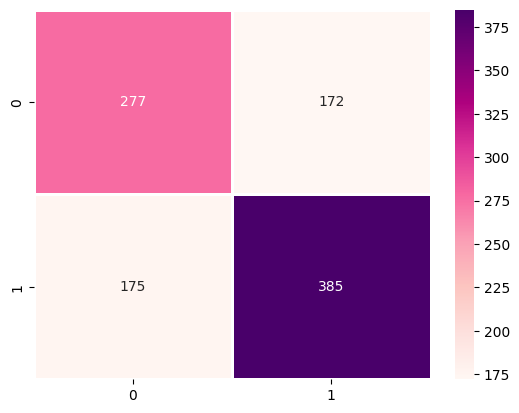


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the RandomForestClassifer model 
               precision    recall  f1-score   support

          No       0.67      0.58      0.62       449
         Yes       0.70      0.77      0.73       560

    accuracy                           0.68      1009
   macro avg       0.68      0.67      0.67      1009
weighted avg       0.68      0.68      0.68      1009
 

Below is the confusion matrix for the RandomForestClassifer model


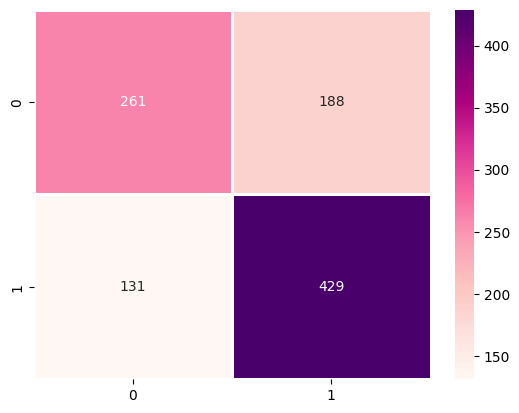


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the KNeighbors model 
               precision    recall  f1-score   support

          No       0.62      0.53      0.57       449
         Yes       0.66      0.73      0.70       560

    accuracy                           0.65      1009
   macro avg       0.64      0.63      0.63      1009
weighted avg       0.64      0.65      0.64      1009
 

Below is the confusion matrix for the KNeighbors model


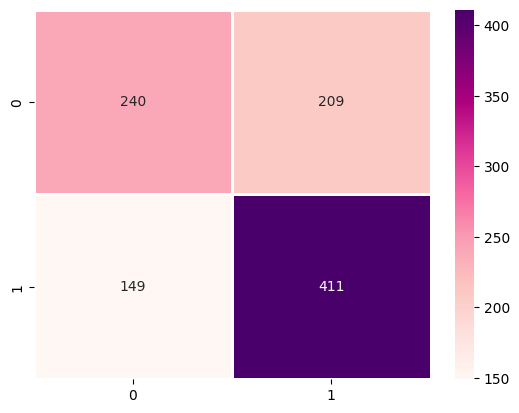


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the Logistics regression model 
               precision    recall  f1-score   support

          No       0.69      0.58      0.63       449
         Yes       0.70      0.80      0.75       560

    accuracy                           0.70      1009
   macro avg       0.70      0.69      0.69      1009
weighted avg       0.70      0.70      0.69      1009
 

Below is the confusion matrix for the Logistics regression model


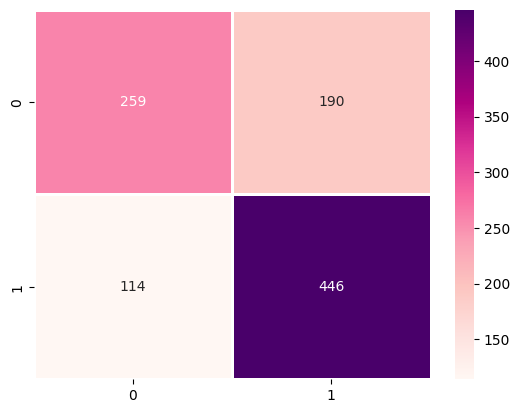


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 



accuracy  precision    recall  f1_score
model                                                         
Logistics regression   0.698712   0.698193  0.698712  0.694356
RandomForestClassifer  0.683845   0.682180  0.683845  0.680787
Decision_Tree          0.656095   0.656328  0.656095  0.656206
KNeighbors             0.645193   0.642462  0.645193  0.641512

In [67]:
all_models_eval, trained_models= model_report()
all_models_eval